## Описание

В файле .bin записан сигнал, полученный с фотодиода. В первых 22 битах записаны параметры измерения, далее – сами значения. (типы данных из языка C).




In [1]:
#0    uint8_t n       //num channels in sample
#1    uint8_t order   //1 - group by sample , 0 - group by channel
#2    int32_t N       //num scans
#6    double dt       //time between neighbour scans in seconds
#14   double V/count
#22   int16_t[]       //data

1. Открываем файл в двоичном режиме (‘rb’)
2. Сканируем первые 22 бита. Для этого используем библиотеку «struct» (а именно struct.unpack). Если нужно, создаем соответствующие переменные (см. табл.)
3. За 41 секунду измерений получаем 51250000 значений.  С учётом того, что с этими данными ещё нужно работать, то есть создавать дополнительные списки (причем после преобразования Фурье тип будет уже не int, а float, а значит, данные будут занимать ещё больше памяти), все значения одновременно не поместятся в оперативной памяти компьютера. Выгружать данные на диск в процессе выполнения тоже не выгодно, потому что резко падает скорость вычислений. Поэтому поделим список на равные части и обработаем их по отдельности. В программе это будет выглядеть как цикл.
4. Данные представляют собой последовательность экспонент, которые могут накладываться друг на друга. Задача – убрать наложение, но при этом сохранить достаточное разрешение сигнала по времени. Предварительно необходимо выделить самую первую экспоненту, соответствующую первому импульсу и аппроксимировать методом наименьших квадратов. Для дальнейшей обработки важен только параметр затухания экспоненты, причем он будет одинаковый для всех импульсов во всех измерениях, т.к. определяется измерительным прибором.
5. Заметим, что свёртка дельта-функции с любой функцией равна этой функции, сдвинутой по оси X в соответствии с нулём аргумента дельта-функции. В частности, свёртка дельта функции (нормированной) с экспонентой даёт такую же экспоненту. Тогда можем считать последовательность экспонент, полученную в эксперименте, результатом свёртки последовательности дельта функций с одной экспонентой (нормированной на единичную площадь), определяемой измерительным прибором. Таким образом, чтобы разделить экспоненты нужно провести обратную свёртку исходных данных с экспонентой, параметр который получен в результате аппроксимации (получая, таким образом, последовательность дельта функций), а затем свернуть результат с новой экспонентой, параметр затухания которой позволяет различить экспоненты.
6. В первые 0,5 секунды измерения лампа выключена, поэтому фиксируется только шумовой сигнал. Считаем его среднее значение и стандартное отклонение. В итоговом спектре не учитываем значения, которые попадают в интервал «средний шум +- 5 сигма».
7. Далее считаем количество импульсов, энергию каждого из них (интеграл) и строим гистограмму. 


# Пример накладывающихся и разрешённых экспонент

<img src="Figure_1.png" width="400">
<img src="Figure_2.png" width="400">

## Используемые библиотеки:

In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import scipy.fftpack as ft
import scipy
from scipy.signal import argrelextrema

## Используемые функции:

In [3]:

def scan1byte(f0):
    #input: f0 - opened "rb" text file
    #scans 1 bytes from the f0 file
    #output: int variable
    #The function needs struct library
    return struct.unpack('<B', f0.read(1))[0]

def scan4bytes(f0):
    #input: f0 - opened "rb" text file
    #scans 4 bytes from the f0 file
    #output: int variable
    #The function needs struct library
    return struct.unpack('<i', f0.read(4))[0]

def scan8bytes(f0):
    #input: f0 - opened "rb" text file
    #scans 8 bytes from the f0 file
    #output: float variable
    #The function needs struct library
    return struct.unpack('<d', f0.read(8))[0]

def scan2bytes(f0):
    #input: f0 - opened "rb" text file
    #scans 2 bytes from the f0 file
    #output: int variable
    #The function needs struct library
    return struct.unpack('<h', f0.read(2))[0]

def scanN0(N0, f0):
    #input: N0 - data lenght, f0 - opened "rb" text file
    #scans N0*2 bytes from the f0 file
    #output: list of int numbers, that has lenght N0
    #The function needs struct library
    z0 = [scan2bytes(f0) for i in range(N0)]
    return z0

def revconv(z0, y0):
    #input: arrays z0 and y0
    #output: reverse convolution of z0 and y0 arrays
    #It needs scipy.fftpack
    return (ft.ifft(ft.fft(z0)/ft.fft(y0))).real

def conv(z0, y0):
    #input: arrays z0 and y0
    #output: convolution of z0 and y0 arrays
    #It needs scipy.fftpack
    return (ft.ifft(ft.fft(z0)*ft.fft(y0))).real



## Функция Analyse для обработки одного файла:

In [4]:
def analyse(file_name0):
    
    #input: file_name0 - input file name or the path
    #output: array of pulse powers
    
    f = open(file_name0+'.bin', "rb")
    scan1byte(f)       # num of channels
    scan1byte(f)       # order: 1 - group by sample , 0 - group by channel
    N = scan4bytes(f)  # num of scans
    dt = scan8bytes(f) # time between neighbour scans
    scan8bytes(f)      # V/count
    
    part = 100            # number of parts
    N1 = N//100           # part of the data for single analyse
    tau0=1.23181E-5       # tau0 parameter. Depends on electrical scheme.
    tau = tau0/3          # parameter that provide resolution of exps.

    x = np.arange(0,N1,1)*dt          # x axis
    exp0 = (1/tau0)*np.exp(-x/tau0)   # old exp
    exp1 = (1/tau)*np.exp(-x/tau)     # new exp
    hist = []

    for i in range(part):
        z = scanN0(N1, f)      # scan
        q = revconv(z, exp0)   # reverse convolution
        q = conv(q, exp1)      # convolution
        
        if i == 0:
            noise_level = np.mean(q[0:400000])+5*np.std(q[0:400000]) # noise signal from the first 0.5 s
            print("Noise level", noise_level)
            
        q = q[q >= noise_level]  # cut noise signal
        print(str(file_name0)+" "+str(int(float(i/part)*100)) + "%", end = '')
        print('\r', end = '')
        
        v = argrelextrema(q, np.greater)              # find all local maxima
        N0 = len(v[0])                                # number of maxima
        for i in range(N0-1):                         # for all maxima
            hist += [np.sum(q[v[0][i]:v[0][i+1]])]    # calculate integral (Energy of pulse)

    print(str(file_name0)+" 100%")
    np.savetxt("hist_"+file_name0+".csv", hist, delimiter = '\n')  # save array of pulses energy
    f.close()

In [5]:
analyse('0_Ar1Xe25.0')   # calculate for one file

Noise level 210.83860706585403
0_Ar1Xe25.0 100%


## Функция, которая строит гистограмму и вычисляет основные параметры (количество импульсов, среднюю энергию, максимальную энергию и количество эффективных импульсов)

In [6]:
def plot_hist(file_name0, bins):
    
    # input: file name, number of bins
    # output: string with file_name; N; Max_E; Mean_E; E_eff
    
    plt.style.use('classic')   # set plot style
    plt.grid(True)
    
    z = np.genfromtxt("hist_"+file_name0+".csv", delimiter='\n').T    # read file with pulses energy
    print("Number of pulses: ", len(z))
    print("Max: ", max(z))
    print("Mean: ", sum(z)/len(z))
    
    x0 = plt.hist(z, bins)      # plot hist
    x = x0[1][0:-1]             # x axis
    y = x0[0][0:]               # y axis
    np.savetxt(file_name0+"_plot.csv", np.array([x, y]).T, delimiter = ';') # save hist as plot (one dot for one bin)
    plt.title(file_name0)
    plt.xlabel('Energy')
    plt.ylabel('Number of pulses')
    plt.savefig(file_name0+'.png')    # save hist as png
    plt.show()                        # show hist in the window (or in notebook in Jupyter)
    plt.clf()
    return file_name0+";"+str(len(z))+";"+str(max(z))+";"+str(sum(z)/len(z))+";"+str(sum(z)/max(z))+"\n"


Number of pulses:  1202670
Max:  549237.7346710248
Mean:  145884.8340903383


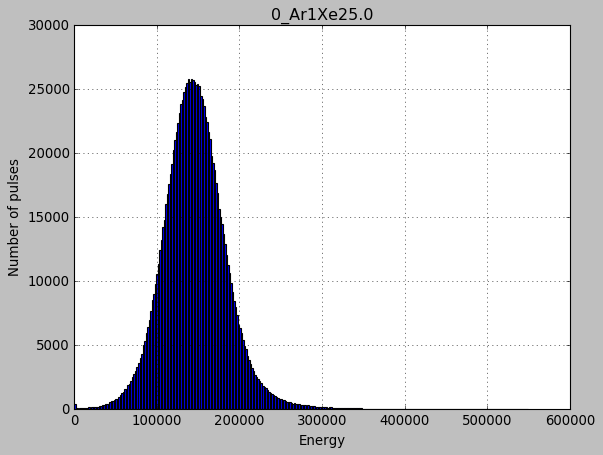

0_Ar1Xe25.0 hist is ready!


<Figure size 640x480 with 0 Axes>

In [7]:
lst_names = ['0_Ar1Xe25.0']       # list of file names
f = open('results.csv', 'w')      # open file to write the results
f.write("file_name; N; Max_E; Mean_E; E_eff \n") # write the results

for x in lst_names:               # cycle for all files
    f.write(plot_hist(x, 300))    
    print(x, 'hist is ready!')

f.close()